In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import jit
import optax
import haiku as hk
import re
from tqdm import tqdm
from pathlib import Path

from tensorflow_probability.substrates import jax as tfp
tfb = tfp.bijectors
tfd = tfp.distributions


from normflow_models import (AffineCoupling,
                             AffineSigmoidCoupling,
                             ConditionalRealNVP)

2025-05-02 10:06:42.630855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746173202.648654 1193022 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746173202.653981 1193022 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746173202.668754 1193022 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746173202.668777 1193022 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746173202.668778 1193022 computation_placer.cc:177] computation placer alr

In [2]:
#class to Train the compressor, in our case we are going to train 
#the compressor with the vmim, so we will also need a Normalizing Flow 
#  which is going to be trained with the compressor

class TrainModel:
    def __init__(
        self,
        compressor,
        nf,
        optimizer,
        loss_name,
        dim=None,
        info_compressor=None,
    ):
        self.compressor = compressor
        self.nf = nf
        self.optimizer = optimizer
        self.dim = dim  # summary statistic dimension

        if loss_name == "train_compressor_mse":
            self.loss = self.loss_mse
        elif loss_name == "train_compressor_vmim":
            self.loss = self.loss_vmim
        elif loss_name == "train_compressor_gnll":
            self.loss = self.loss_gnll
            if self.dim is None:
                raise ValueError("dim should be specified when using gnll compressor")
        elif loss_name == "loss_for_sbi":
            if info_compressor is None:
                raise ValueError("sbi loss needs compressor informations")
            else:
                self.info_compressor = info_compressor
                self.loss = self.loss_nll

    def loss_mse(self, params, theta, x, state_resnet):
        """Compute the Mean Squared Error loss"""
        y, opt_state_resnet = self.compressor.apply(params, state_resnet, None, x)

        loss = jnp.mean(jnp.sum((y - theta) ** 2, axis=1))

        return loss, opt_state_resnet

    def loss_mae(self, params, theta, x, state_resnet):
        """Compute the Mean Absolute Error loss"""
        y, opt_state_resnet = self.compressor.apply(params, state_resnet, None, x)

        loss = jnp.mean(jnp.sum(jnp.absolute(y - theta), axis=1))

        return loss, opt_state_resnet

    def loss_vmim(self, params, theta, x, state_resnet):
        """Compute the Variational Mutual Information Maximization loss"""
        y, opt_state_resnet = self.compressor.apply(params, state_resnet, None, x)
        log_prob = self.nf.apply(params, theta, y)

        return -jnp.mean(log_prob), opt_state_resnet

    def loss_gnll(self, params, theta, x, state_resnet):
        """Compute the Gaussian Negative Log Likelihood loss"""
        y, opt_state_resnet = self.compressor.apply(params, state_resnet, None, x)
        y_mean = y[..., : self.dim]
        y_var = y[..., self.dim :]
        y_var = tfb.FillScaleTriL(diag_bijector=tfb.Softplus(low=1e-3)).forward(y_var)

        @jax.jit
        @jax.vmap
        def _get_log_prob(y_mean, y_var, theta):
            likelihood = tfd.MultivariateNormalTriL(y_mean, y_var)
            return likelihood.log_prob(theta)

        loss = -jnp.mean(_get_log_prob(y_mean, y_var, theta))

        return loss, opt_state_resnet

    def loss_nll(self, params, theta, x, _):
        """Compute the Negative Log Likelihood loss.
        This loss is for inference so it requires to have a trained compressor.
        """
        y, _ = self.compressor.apply(
            self.info_compressor[0], self.info_compressor[1], None, x
        )
        log_prob = self.nf.apply(params, theta, y)

        return -jnp.mean(log_prob), _

    @partial(jax.jit, static_argnums=(0,))
    def update(self, model_params, opt_state, theta, x, state_resnet=None):
        (loss, opt_state_resnet), grads = jax.value_and_grad(self.loss, has_aux=True)(
            model_params, theta, x, state_resnet
        )

        updates, new_opt_state = self.optimizer.update(grads, opt_state)

        new_params = optax.apply_updates(model_params, updates)

        return loss, new_params, new_opt_state, opt_state_resnet

In [3]:
from typing import NamedTuple

#mimic the argument parser used in the sbi_bm_lens

class args_namedtuple(NamedTuple):

    total_steps = 10_000,

    loss = "train_compressor_vmim",
    # loss = "train_compressor_mse",


args = args_namedtuple()
dim = 10
N_particles = 10_000


In [4]:
### create compressor 

#nf 
bijector_layers_compressor = [128] * 2

bijector_compressor = partial(
    AffineCoupling, layers=bijector_layers_compressor, activation=jax.nn.silu
)

NF_compressor = partial(ConditionalRealNVP, n_layers=4, bijector_fn=bijector_compressor)


class Flow_nd_Compressor(hk.Module):
    def __call__(self, y):
        nvp = NF_compressor(dim)(y)
        return nvp


nf = hk.without_apply_rng(
    hk.transform(lambda theta, y: Flow_nd_Compressor()(y).log_prob(theta).squeeze())
)

In [5]:
if args.loss == "train_compressor_gnll":
    compress_dim = int(dim + ((dim**2) - dim) / 2 + dim)
else:
    compress_dim = dim

In [6]:
# class DeepSetsEncoder(hk.Module):
#     def __init__(self, output_dim, hidden_dim: int = 128, name=None):
#         super().__init__(name=name)
#         self.hidden_dim = hidden_dim
#         self.output_dim = output_dim

#     def __call__(self, x):  # x: [N_particles, 6]
#         # φ network: shared across all particles
#         mlp_phi = hk.nets.MLP([self.hidden_dim, self.hidden_dim, self.output_dim])
#         x_phi = mlp_phi(x)  # shape: [N_particles, output_dim]

#         # Pooling over the set dimension (e.g., mean, sum)
#         summary = jnp.mean(x_phi, axis=0)  # shape: [output_dim]

#         return summary


class DeepSetsEncoder(hk.Module):
    def __init__(self, output_dim, hidden_dim: int = 128, name=None):
        super().__init__(name=name)
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

    def __call__(self, x):  # x: [N_particles, 6] or [B, N_particles, 6]
        mlp_phi = hk.nets.MLP([self.hidden_dim, self.hidden_dim, self.hidden_dim, self.output_dim])

        if x.ndim == 2:
            # Unbatched case: [N_particles, 6]
            x_phi = mlp_phi(x)  # [N_particles, output_dim]
            summary = jnp.mean(x_phi, axis=0)  # [output_dim]
        elif x.ndim == 3:
            # Batched case: [B, N_particles, 6]
            # Flatten for MLP: [B * N_particles, 6]
            B, N, D = x.shape
            x_flat = x.reshape(-1, D)
            x_phi_flat = mlp_phi(x_flat)  # [B * N_particles, output_dim]
            x_phi = x_phi_flat.reshape(B, N, self.output_dim)
            summary = jnp.mean(x_phi, axis=1)  # [B, output_dim]
        else:
            raise ValueError(f"Input must be of shape (N, D) or (B, N, D), got {x.shape}")

        return summary

In [7]:
compressor = hk.transform_with_state(
    lambda y: DeepSetsEncoder(compress_dim)(y)
)

In [8]:
### TRAIN
# init compressor
parameters_SetNet, opt_state_SetNet = compressor.init(
    jax.random.PRNGKey(0), y=jnp.ones([1, N_particles, 6])
)

# init nf
params_nf = nf.init(
    jax.random.PRNGKey(0), theta=0.5 * jnp.ones([1, 5]), y=0.5 * jnp.ones([1, dim])
)


In [ ]:
if args.loss[0] == "train_compressor_vmim":
    parameters_compressor = hk.data_structures.merge(parameters_SetNet, params_nf)
elif args.loss[0] in [
    "train_compressor_mse",
    "train_compressor_mae",
    "train_compressor_gnll",
]:
    parameters_compressor = parameters_SetNet


# define optimizer
total_steps = args.total_steps[0]

if args.loss == "train_compressor_gnll":
    start_lr = 0.0001

else:
    start_lr = 0.001

lr_scheduler = optax.piecewise_constant_schedule(
    init_value=start_lr,
    boundaries_and_scales={
        int(total_steps * 0.1): 0.7,
        int(total_steps * 0.2): 0.7,
        int(total_steps * 0.3): 0.7,
        int(total_steps * 0.4): 0.7,
        int(total_steps * 0.5): 0.7,
        int(total_steps * 0.6): 0.7,
        int(total_steps * 0.7): 0.7,
        int(total_steps * 0.8): 0.7,
        int(total_steps * 0.9): 0.7,
    },
)

optimizer_c = optax.adam(learning_rate=lr_scheduler)
opt_state_c = optimizer_c.init(parameters_compressor)

model_compressor = TrainModel(
    compressor=compressor,
    nf=nf,
    optimizer=optimizer_c,
    loss_name=args.loss[0],
)


update = jax.jit(model_compressor.update)


#load data
data_path = './data/data_NFW/'
pattern = re.compile(r"chunk_(\d+)\.npz")  # capture any number of digits
files = sorted(
    f for f in Path(data_path).glob("chunk_*.npz")
    if (m := pattern.fullmatch(f.name)) and int(m.group(1)) < 9500
)
theta_list, x_list, score_list = [], [], []

for f in files:
    data = np.load(f)
    theta_list.append(data["theta"])
    x_list.append(data["x"])
    score_list.append(data["score"]) 



# dataset_theta = np.array(theta_list,).reshape(-1, 5)
# dataset_y = np.array(x_list, ).reshape(-1, 10_000, 6)
# dataset_score = np.stack(score_list,).reshape(-1, 5)

dataset_theta = np.array(theta_list)
dataset_theta = dataset_theta[~np.isnan(dataset_theta)]
dataset_theta = dataset_theta.reshape(-1, 5)
dataset_y = np.array(x_list)
dataset_y = dataset_y[~np.isnan(dataset_y)]
dataset_y = dataset_y.reshape(-1, 10_000, 6)
dataset_score = np.stack(score_list)
dataset_score = dataset_score[~np.isnan(dataset_score)]
dataset_score = dataset_score.reshape(-1, 5)



#normalization function
# @partial(jax.jit, static_argnums=(1,2))
def normalize(dataset, is_observable = False, dataset_name = None):
    if is_observable:
        # the shape in this case is (N, N_particles, 6)
        dataset_original_shape = dataset.shape
        normalized_dataset = dataset.reshape(-1, dataset.shape[-1])
        mean = np.mean(normalized_dataset, axis=0)
        std = np.std(normalized_dataset, axis=0)
        normalized_dataset = (normalized_dataset - mean)/ (std + 1e-8) 
        normalized_dataset = normalized_dataset.reshape(dataset_original_shape)
    else:
        mean = np.mean(dataset, axis=0)
        std = np.std(dataset, axis=0)
        normalized_dataset = (dataset - mean)/ (std + 1e-8) 

    print(f"mean: {mean}, std: {std}")
    
    if dataset_name is not None:
        jnp.savez(
            f"./params_compressor/normalization_for_compressor_{dataset_name}.npz",
            mean=mean,
            std=std,
        )

    return normalized_dataset

dataset_theta = jnp.array(normalize(dataset_theta, dataset_name="theta"))
dataset_y = jnp.array(normalize(dataset_y, is_observable=True, dataset_name="y"))
dataset_score = jnp.array(normalize(dataset_score, dataset_name="score"))


store_loss = []
for batch in tqdm(range(total_steps + 1)):
    # batch = np.random.randint(0, len(dataset_theta), 1)
    theta = dataset_theta[batch]
    x = dataset_y[batch]
    score = dataset_score[batch]
    # print(f"theta: {theta.shape}, x: {x.shape}, score: {score.shape}")
    if not jnp.isnan(score).any():
        b_loss, parameters_compressor, opt_state_c, opt_state_SetNet = update(
            model_params=parameters_compressor,
            opt_state=opt_state_c,
            theta=theta,
            x=x,
            state_resnet=opt_state_SetNet,
        )
        store_loss.append(b_loss)

        if jnp.isnan(b_loss):
            print("NaN Loss")
            break

  0%|          | 1/10001 [00:03<10:27:19,  3.76s/it]

NaN Loss


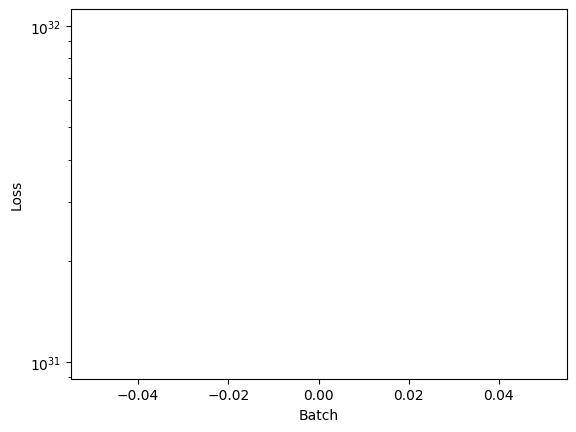

In [10]:
plt.plot(store_loss)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.yscale('log')
# plt.yscale("log")

In [11]:
# batch_size = 128
# num_batches = dataset_theta.shape[0] // batch_size

# def get_batch(x_data, theta_data, score_data, batch_size, batch_idx):
#     start = batch_idx * batch_size
#     end = start + batch_size
#     return x_data[start:end], theta_data[start:end], score_data[start:end]

# store_loss = []
# for batch_idx in range(num_batches):
#     x_batch, theta_batch, score_batch = get_batch(dataset_y, dataset_theta, dataset_score, batch_size, batch_idx)
#     print(x_batch.shape, theta_batch.shape, score_batch.shape)
    
#     if not jnp.isnan(score_batch).any():
#         b_loss, parameters_compressor, opt_state_c, opt_state_SetNet = update(
#             model_params=parameters_compressor,
#             opt_state=opt_state_c,
#             theta=theta_batch,
#             x=x_batch,
#             state_resnet=opt_state_SetNet,
#         )
#         store_loss.append(b_loss)

#         if jnp.isnan(b_loss):
#             print("NaN Loss")
#             break

In [12]:
#run the compressor 

compress_data, _ = compressor.apply(
    parameters_compressor, opt_state_SetNet, None, dataset_y[:2]
)

In [13]:
compress_data.shape

(2, 10)

In [14]:
# save the model 
import pickle

with open(
    "./params_compressor/params_nd_compressor_vmim.pkl", "wb"
) as fp:
    pickle.dump(parameters_compressor, fp)

with open("./params_compressor/opt_state_SetNet_vmim.pkl", "wb") as fp:
    pickle.dump(opt_state_SetNet, fp)
    